In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from datasets import load_dataset
import datasets
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

train_size = 1000

dataset = load_dataset("opus_books", "en-fr")["train"] # Take the training part of the dataset
dataset = dataset.train_test_split(test_size=0.2)      # Split the dataset into "train" and "test"
tokenizer = AutoTokenizer.from_pretrained("t5-small")  # Get the tokenizer

# make the tokenize_function
def tokenize_function(dataset):
    input_outputs = dataset["translation"]
    inputs = [input_output["en"] for input_output in input_outputs]
    outputs = [input_output["fr"] for input_output in input_outputs]
    return tokenizer(inputs, text_target=outputs, truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Make a smaller dataset
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(train_size))
small_eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(train_size))

Map:   0%|          | 0/101668 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

In [131]:
train_input = small_train_dataset["input_ids"]
train_output = small_train_dataset["labels"]
print(len(tokenizer))
print(tokenizer.vocab_size)
source_vocab_size = tokenizer.vocab_size + 2
target_vocab_size = tokenizer.vocab_size + 2

32100
32100


In [132]:
class Seq2SeqEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, source_vocab_size):
        super(Seq2SeqEncoder, self).__init__()
                
        self.embedding_table = nn.Embedding(source_vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x_embedding = self.embedding_table(x)
        output, (h_n, c_n) = self.lstm_layer(x_embedding)
        return output, h_n
    
    

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
                
    def forward(self, decoder_ht, encoder_h):
        # decoder_ht: bs * D
        # encoder_h: bs * L * D
        score = (decoder_ht.unsqueeze(1) * encoder_h).sum(-1)  # e
        attention_prob = torch.softmax(score, dim=-1)  # a
        context = (attention_prob.unsqueeze(-1) * encoder_h).sum(1)  # c_t
        return attention_prob, context
    
    
    
class Seq2SeqDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, target_vocab_size, start_id, end_id):
        super(Seq2SeqDecoder, self).__init__()
        
        self.num_classes = num_classes
                
        self.embedding_table = nn.Embedding(target_vocab_size, embedding_dim)
        self.lstm_cell = nn.LSTMCell(embedding_dim, hidden_dim)  # one single step
        self.attention = Attention()
        self.proj_layer = nn.Linear(2 * hidden_dim, num_classes)
        self.start_id = start_id
        self.end_id = end_id

    def forward(self, shifted_target_ids, encoder_h):
        
        shifted_target_embedding = self.embedding_table(shifted_target_ids)
        
        bs, target_len = shifted_target_ids.shape
        source_len = encoder_h.shape[1]
        logits = torch.zeros(bs, target_len, self.num_classes)
        attention_probs = torch.zeros(bs, target_len, source_len)
                
        for t in range(0, target_len):
            decoder_input_t = shifted_target_embedding[:, t, :]
            if t == 0:
                decoder_ht, decoder_ct = self.lstm_cell(decoder_input_t)
            else:
                decoder_ht, decoder_ct = self.lstm_cell(decoder_input_t, (decoder_ht, decoder_ct))
            attention_prob, context = self.attention(decoder_ht, encoder_h)   
            
            hn_and_context = torch.cat((decoder_ht, context), dim=-1)
            logit = self.proj_layer(hn_and_context)
            
            logits[:, t, :] = logit
            attention_probs[:, t, :] = attention_prob
            
        return logits, attention_prob
            
    def inference(self, encoder_h):
        result = [self.start_id]
                        
        for t in range(0, 128):
            decoder_input_t = self.embedding_table(result[-1])[:, 0, :]
            if t == 0:
                decoder_ht, decoder_ct = self.lstm_cell(decoder_input_t)
            else:
                decoder_ht, decoder_ct = self.lstm_cell(decoder_input_t, (decoder_ht, decoder_ct))
                
            attention_prob, context = self.attention(decoder_ht, encoder_h)   
            
            hn_and_context = torch.cat((decoder_ht, context), dim=-1)
            logit = self.proj_layer(hn_and_context)
            
            target_id = torch.argmax(logit)
            if target_id == self.end_id:
                break
            
            result.append(torch.tensor([[target_id]]))
            
        return torch.stack(result[1:], dim=0)
    
    
class Seq2SeqModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, source_vocab_size, target_vocab_size, start_id, end_id):
        super(Seq2SeqModel, self).__init__()
        self.encoder = Seq2SeqEncoder(embedding_dim, hidden_dim, source_vocab_size)
        self.decoder = Seq2SeqDecoder(embedding_dim, hidden_dim, num_classes, target_vocab_size, start_id, end_id)
        
    def forward(self, source_ids, shifted_target_ids):
        encoder_output, encoder_h = self.encoder(source_ids)
        logits, attention_prob = self.decoder(shifted_target_ids, encoder_h)
        
        return logits, attention_prob
    
    def inference(self, source_ids):
        encoder_output, encoder_h = self.encoder(source_ids)
        return self.decoder.inference(encoder_h)

In [133]:
train_size = 1000
start_id = source_vocab_size - 2
end_id = source_vocab_size - 1
start_id = start_id * torch.ones(1, 1).long()
end_id = end_id * torch.ones(1, 1).long()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2SeqModel(64, 128, target_vocab_size, source_vocab_size, target_vocab_size, start_id, end_id).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_list = []

def train(iters = 1000):
    for iter in tqdm(range(iters)):
        iter_loss = 0
        for i in range(train_size):
            source_token   =   torch.tensor(small_train_dataset["input_ids"][i]).unsqueeze(0).long().to(device)
            target_token   =   torch.tensor(small_train_dataset["labels"][i]).unsqueeze(0).long().to(device)
            target_token = torch.cat((start_id, target_token[:, 0:-1], end_id), dim=1).long()
            
            pred_logits, attention_probs = model(source_token, target_token)
            pred_prob = torch.softmax(pred_logits, dim=-1)
            loss = criterion(pred_logits.permute(0, 2, 1).float(), target_token.long())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iter_loss += loss.data
        loss_list.append(iter_loss)
        
train()

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [122]:
def translate(input):
    source_token = tokenizer.encode(input)
    source_token = torch.tensor(source_token).unsqueeze(dim=0).long()
    output_id = model.inference(source_token)
    output = tokenizer.decode(output_id.squeeze().squeeze())
    return output


translate("hello")

torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_h

torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_ht shape: torch.Size([1, 128])
Encoder_h shape: torch.Size([1, 1, 128])
torch.Size([1, 1])
torch.Size([1, 64])
Decoder_h

'nez apropie sprint plin sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These obsThere sprint documentary 27, These Thesenez These'

In [57]:
import matplotlib.pyplot as plt

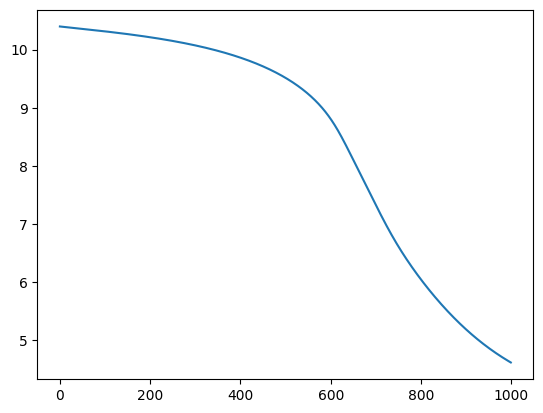

In [121]:
plt.plot(loss_list)

In [124]:
torch.ones(1, 1) == torch.ones(1)

tensor([[True]])